In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

# Cargando el Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading the dataset
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Semana12_Clustering/marketing_campaign.csv", sep="\t")
print("Numero de observaciones:", len(data))
data.head()

Numero de observaciones: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Sobre el Dataset:


*   Informacion de los clientes:
ID,	Year_Birth,	Education,	Marital_Status,	Income (ingresos),	Kidhome (niños),	Teenhome(adolescentes),	Dt_Customer,	Recency (dias desde ultima compra), Complain (quejas en el ultimo año)
*   Tipo de productos comprados: MntWines,	MntFruits,	MntMeatProducts,	MntFishProducts,	MntSweetProducts,	MntGoldProds
*   Canal de compra: NumWebPurchases,	NumCatalogPurchases,	NumStorePurchases,	NumWebVisitsMonth
*   Impactos comerciales:
NumDealsPurchases (compras con descuento), cceptedCmp3,	AcceptedCmp4,	AcceptedCmp5,	AcceptedCmp1,	AcceptedCmp2, Response (respuesta ultima campaña)



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

**Podemos concluir que:**

* Hay nulos en income (ingresos)
* Dt_Customer tiene mal el tipo de dato, hay que parsearlo a datetime
* Hay variables categóricas (dtype:object)


In [ ]:
#Removemos los nulos
data = data.dropna()
print("Filas despues de eliminar nulos:", len(data))

Filas despues de eliminar nulos: 2216


En el próximo paso vamos a crear una variable de antiguedad. Para esto, como no sabemos la fecha en la que se creo el dataset, vamos a suponer que la última fecha de alta de un cliente es la fecha actual.

In [ ]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
fechas = []
for i in data["Dt_Customer"]:
    i = i.date()
    fechas.append(i)
#Fechas de alta del comprador mas antiguo y mas nuevo
print("Mas nuevo:",max(fechas))
print("Mas viejo:",min(fechas))


Mas nuevo: 2014-12-06
Mas viejo: 2012-01-08


<ipython-input-10-27f5db59f3e5>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])


Creamos la variable antiguedad en dias

In [ ]:
dias = []
d1 = max(fechas)
for i in fechas:
    delta = d1 - i
    dias.append(delta)
data["Antiguedad"] = dias
data["Antiguedad"] = pd.to_numeric(data["Antiguedad"], errors="coerce")

Vamos a ver que categorias hay en las  variables categoricas

In [ ]:
print("categorias en  Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Categorias en  Education:\n", data["Education"].value_counts())

categorias en  Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Categorias en  Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


* Vamos a extraer la edad de un comprador por su fecha de nacimiento.
* Total de gasto, que sume los gastos de todas las categorias de productos.
* Vamos a simplificar algunas categorias, transformando marital_status en si vive con alguien o solo.
* Simplificamos Kidhome y teenhome (niños en casa y adolescentes en casa), la transformamos en "hijos".
* Creamos una variable de total de personas viviendo en la casa.
* Creamos una variable booleana de si es padre/madre o no.
* Simplificamos las variables de educación
* Quitamos variables que no nos sirven

In [ ]:
#Feature Engineering
#Edad a la fecha actual que suponemos que es
data["Edad"] = 2015-data["Year_Birth"]

#Gasto total
data["Gasto"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Compañero
data["Compañero"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Cantidad de hijos
data["Hijos"]=data["Kidhome"]+data["Teenhome"]

#Personas en la casa
data["Familia"] = data["Compañero"].replace({"Alone": 1, "Partner":2})+ data["Hijos"]

#Padres
data["Es_padre"] = np.where(data.Hijos> 0, 1, 0)

#Educación simplificada
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#Aclaración de los productos
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Quitamos variables no útiles
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID", 'Kidhome', 'Teenhome']
data = data.drop(to_drop, axis=1)

Volvemos a mirar los datos.

In [ ]:
data.describe()

,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Antiguedad,Edad,Gasto,Hijos,Familia,Es_padre
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,46.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,19.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,38.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,45.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,56.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,122.000000,2525.000000,3.000000,5.000000,1.000000


Vamos a ver outliers ya que los valores maximos de income y edad se escapan mucho de la media.

<Figure size 800x550 with 0 Axes>

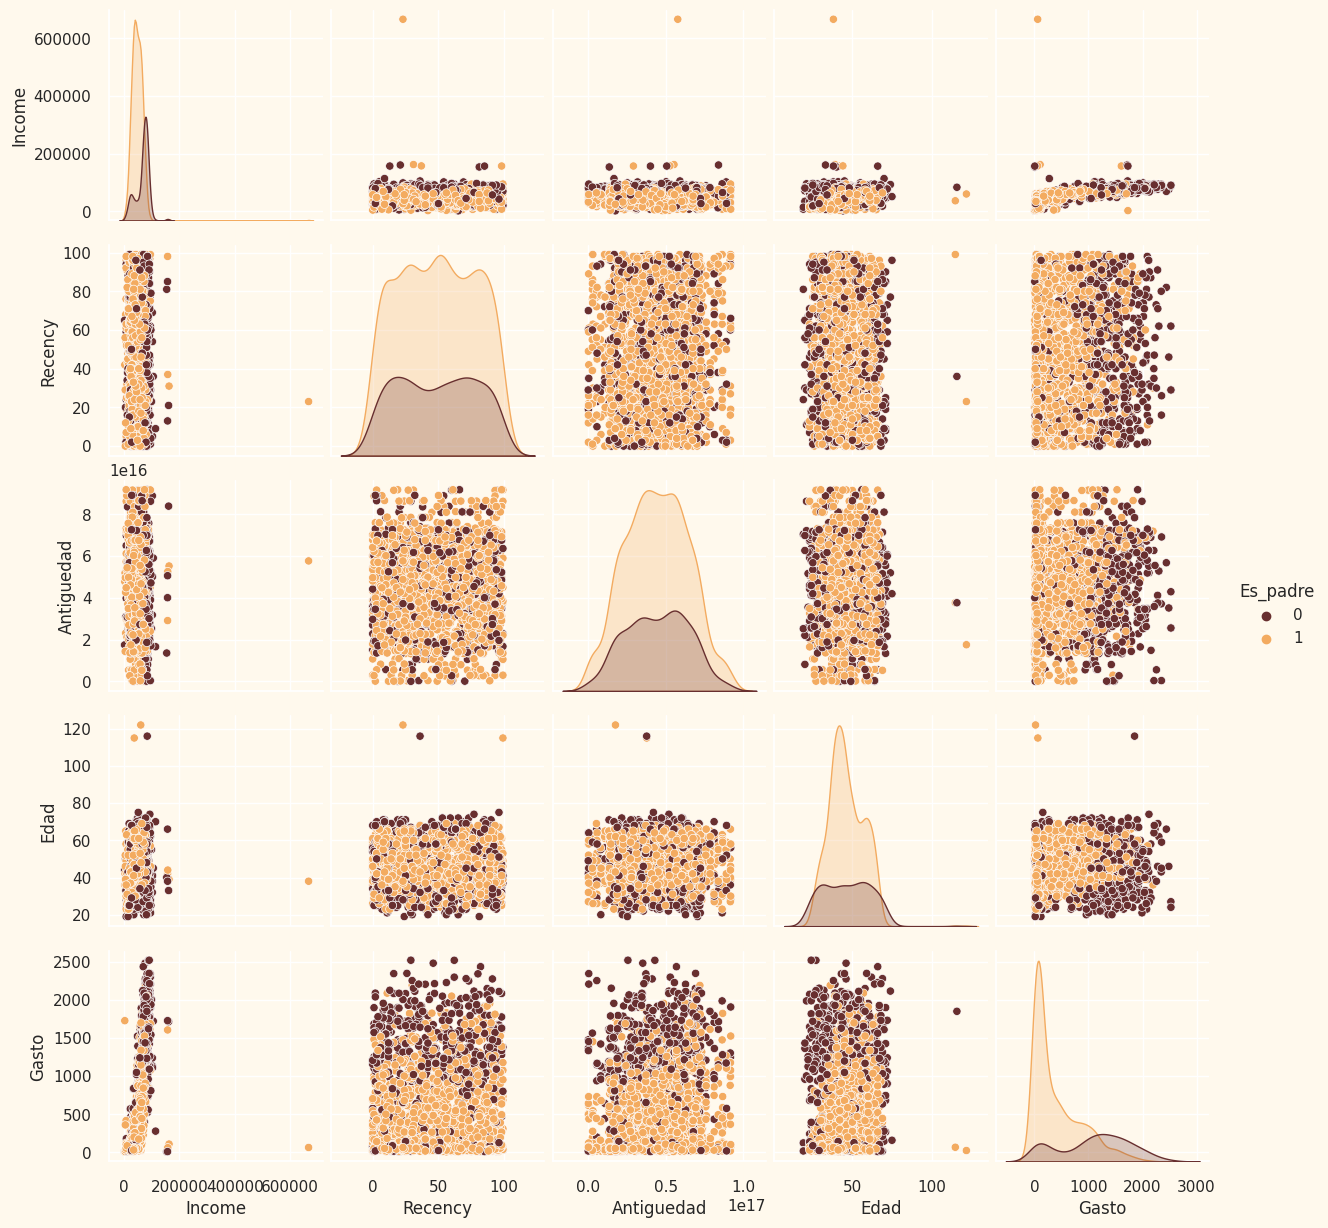

In [ ]:
# Vamos a plotear algunas variables para ver como se distribuyen sus datos
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Antiguedad", "Edad", "Gasto", "Es_padre"]

plt.figure()
sns.pairplot(data[To_Plot], hue= "Es_padre",palette= (["#682F2F","#F3AB60"]))
#Taking hue
plt.show()

Se nota que hay outliers en Income y Edad

In [ ]:
# Le ponemos un tope a los valores de esas variables
data = data[(data["Edad"]<90)]
data = data[(data["Income"]<600000)]
print("Filas restantes:", len(data))

Filas restantes: 2212


Vamos a ver la correlacion entre variables. Excluyendo las categoricas.

<ipython-input-18-8c3b4a74c59e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat= data.corr()


<Axes: >

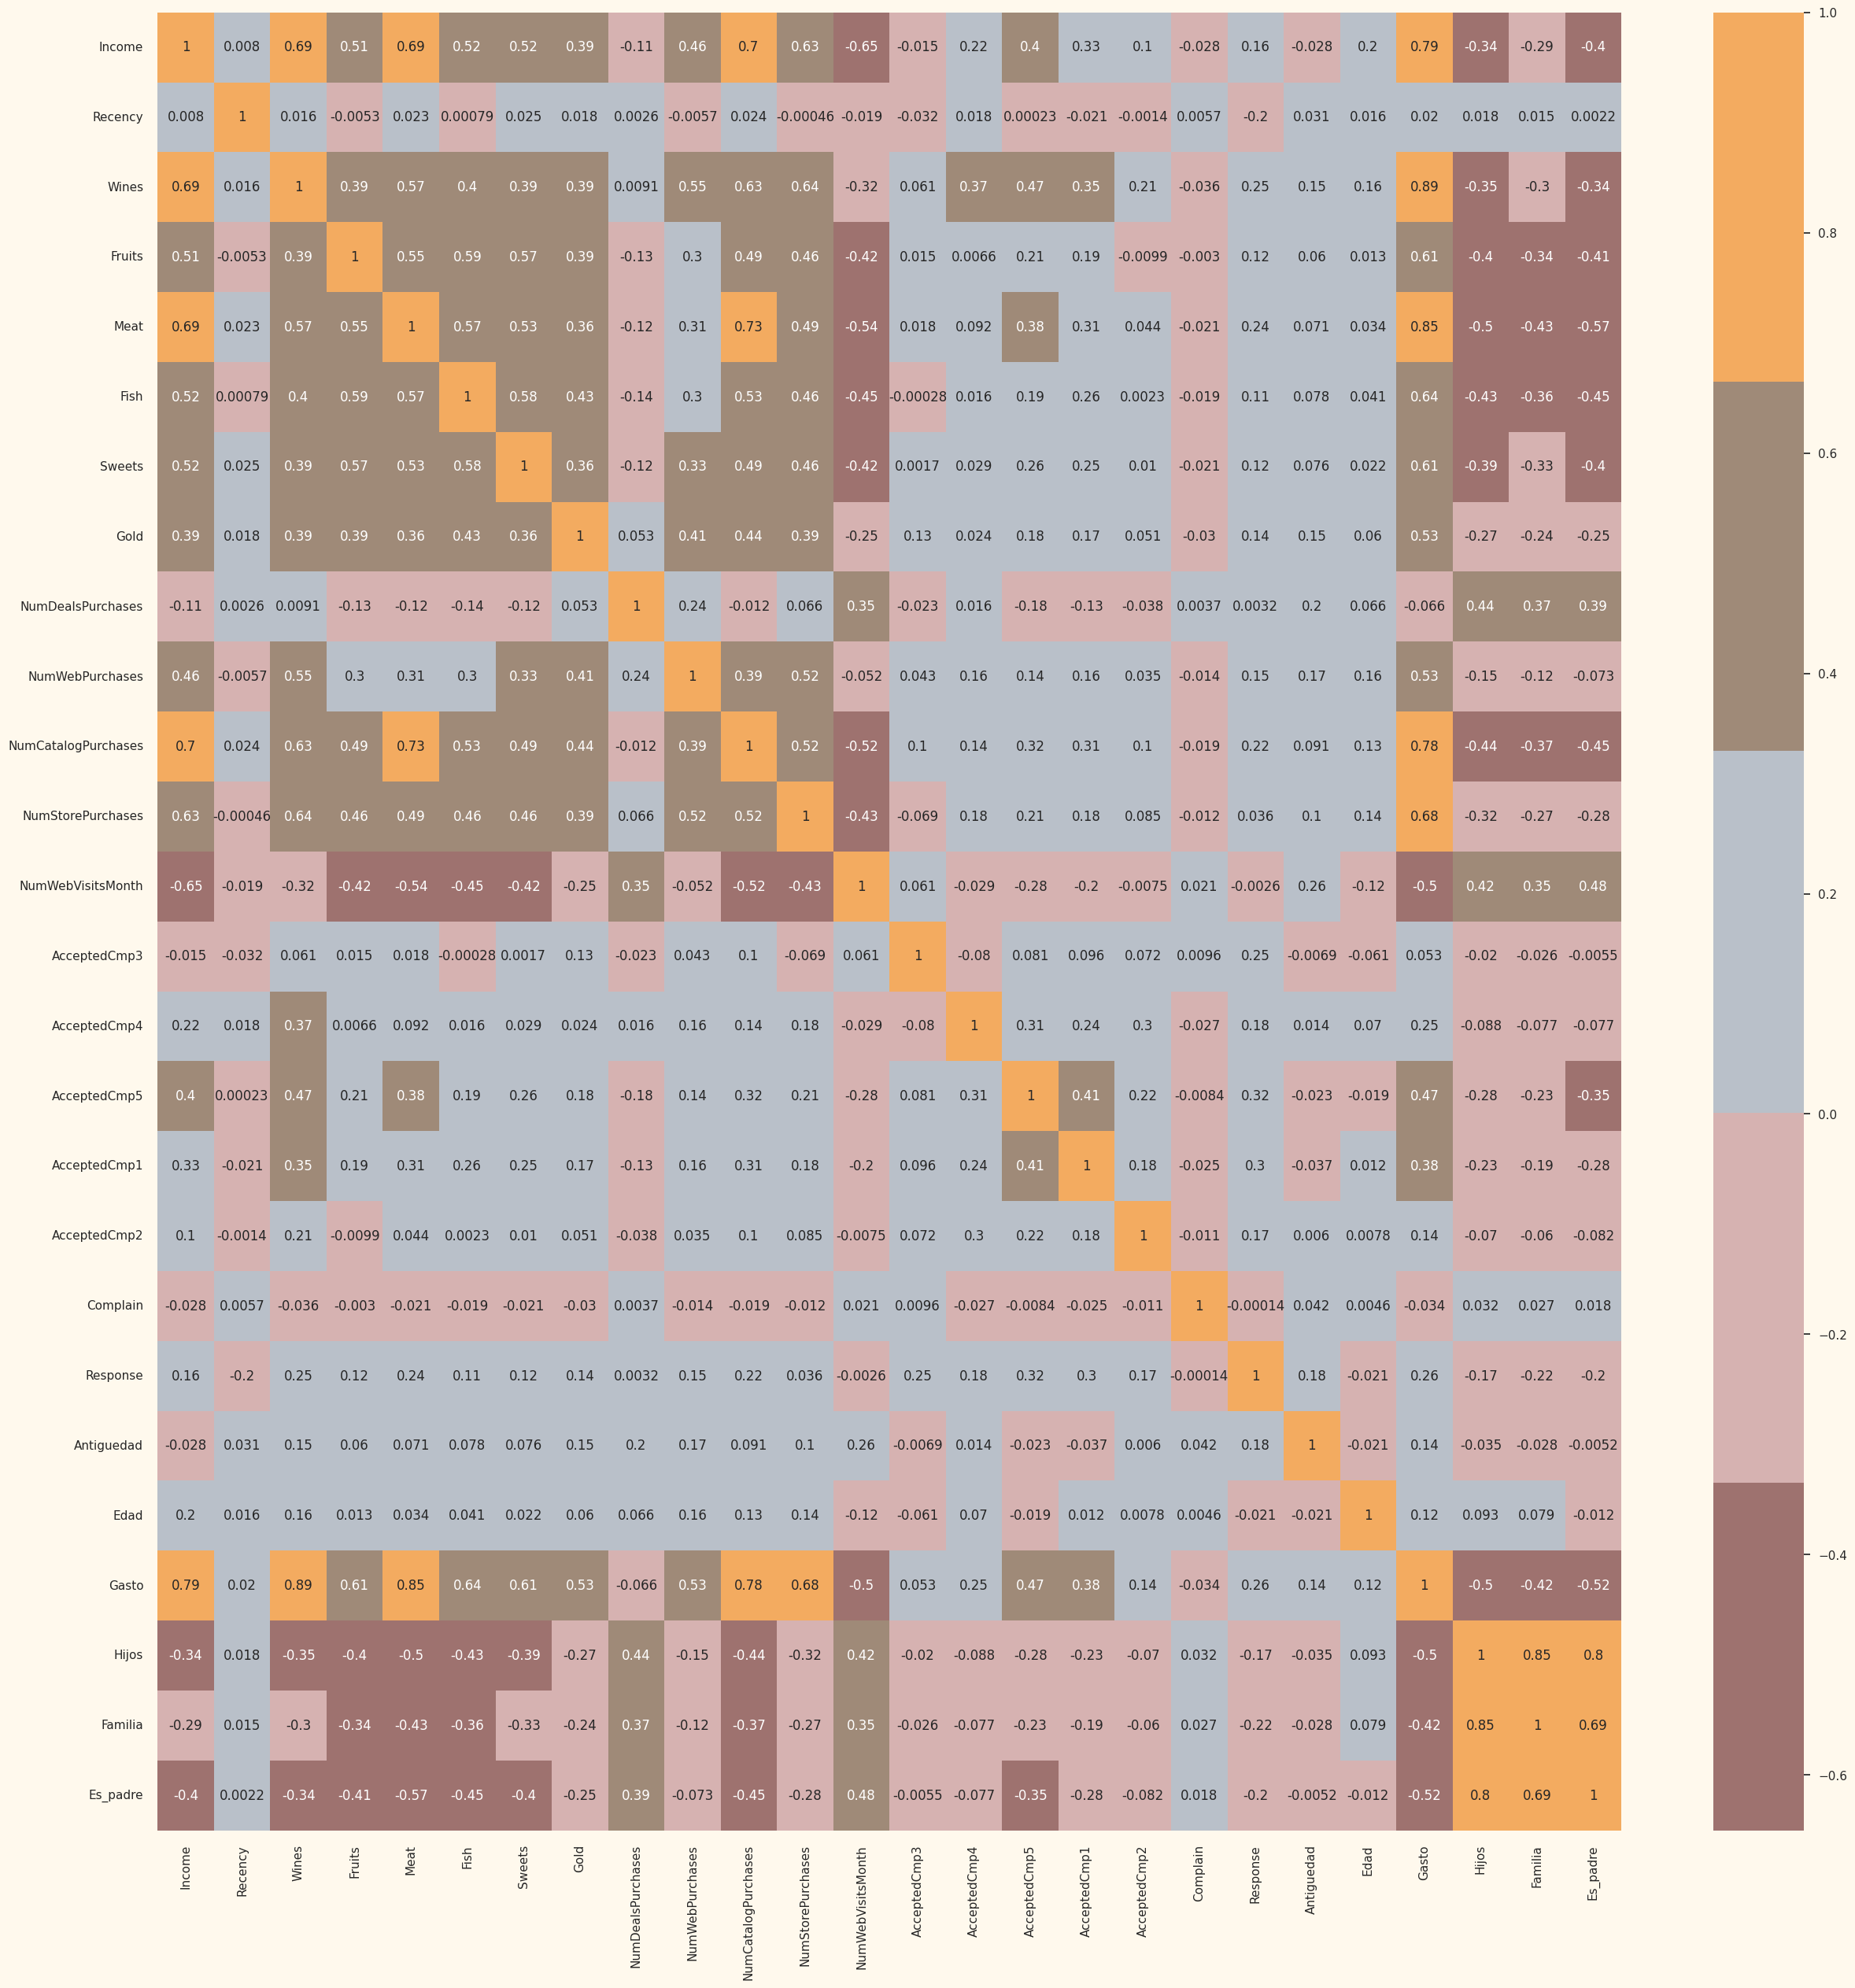

In [ ]:
#correlation matrix
corrmat= data.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

Vamos a preprocesar los datos para poder utilizarlos en el algoritmo

* Label encoding las variables categóricas
* Estandarizar las variables con standar scaler
* Creating a subset dataframe for dimensionality reduction

In [ ]:
#Variables categoricas
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categoricas:", object_cols)

Categoricas: ['Education', 'Compañero']


In [ ]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)


In [ ]:
#Creamos una copia de los datos por si a caso
ds = data.copy()
# Reducimos el dataset un poco mas quitando la parte de impactos de campañas comerciales y la variable Es_padre que es redundante con la de Hijos.
cols_del = [ 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response','Es_padre']
ds = ds.drop(cols_del, axis=1)
#Estandarizamos los datos
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )scaler = StandardScaler()



In [ ]:
scaled_ds.head()

,Education,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Antiguedad,Edad,Gasto,Compañero,Hijos,Familia
0,-0.893586,0.287105,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,-1.349603,-1.264598,-1.758359
1,-0.893586,-0.260882,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.349603,1.404572,0.449070
2,-0.893586,0.913196,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,0.740959,-1.264598,-0.654644
3,-0.893586,-1.176114,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,0.740959,0.069987,0.449070
4,0.571657,0.294307,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.740959,0.069987,0.449070


Reducción de la dimensionalidad

Con el objetivo de poder realizar visualizaciones de los clusters y comprimir los datos en un espacio de dimensiones inferior, vamos a aplicar la técnica de PCA (Principal Componen Analysis)

Para esto reduciremos las dimensiones a 3

In [ ]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,7.066881e-17,2.707036,-5.672191,-2.404682,-0.821974,2.364477,7.285013
col2,2212.0,0.000000e+00,1.467556,-3.788919,-1.042515,-0.165353,0.923204,6.030521
col3,2212.0,4.095579e-17,1.203603,-3.676161,-0.874066,-0.053490,0.816939,6.129067


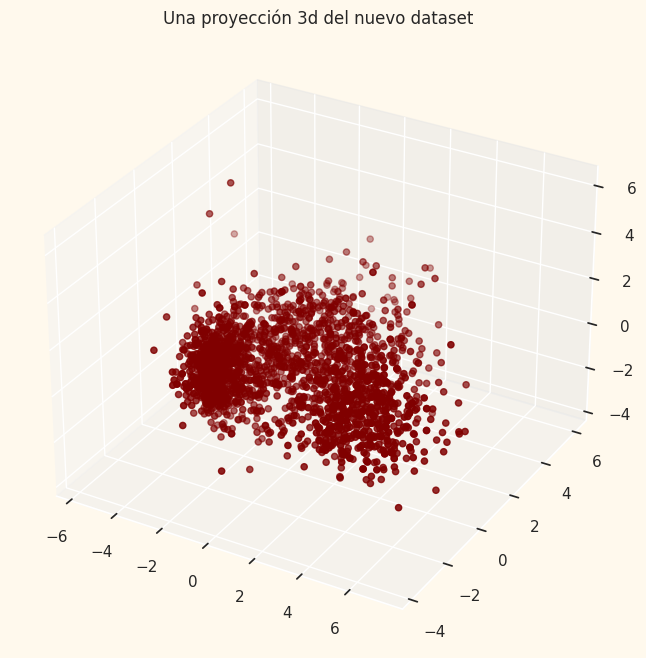

In [ ]:
#Ploteo 3d del nuevo dataset
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("Una proyección 3d del nuevo dataset")
plt.show()

## Clustering


Cantidad de clusters/distorsion:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

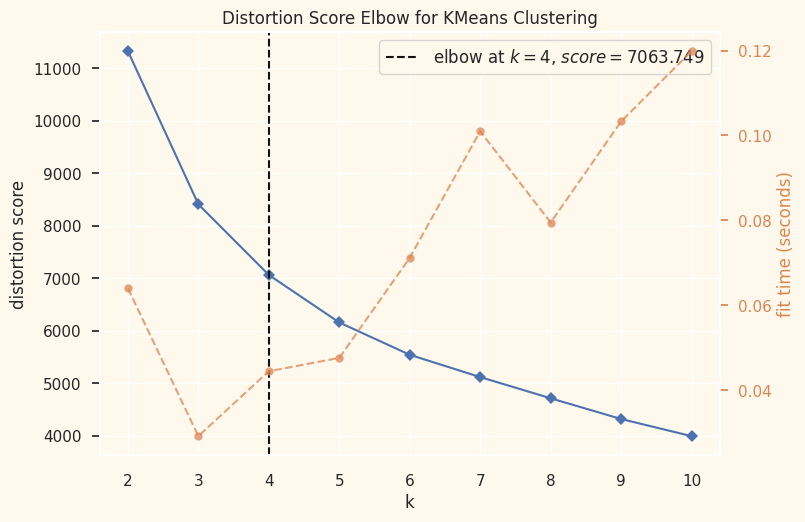

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Método del codo para ver cuantos clusters pedirle al algoritmo (usamos la libreria yellowbrick.cluster).
print('Cantidad de clusters/distorsion:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

El gráfico superior nos indica que cuatro clusters serán los adecuados.

In [ ]:
#Initiating the Agglomerative Clustering model
kmeans = KMeans(n_clusters=4)
pred = kmeans.fit_predict(PCA_ds)
PCA_ds["Clusters"] = pred
#Añadimos la etiqueta de clusters al dataset original para poder analizarlo
data["Clusters"]= pred

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pintamos los clusters sobre el ploteo 3d de los datos

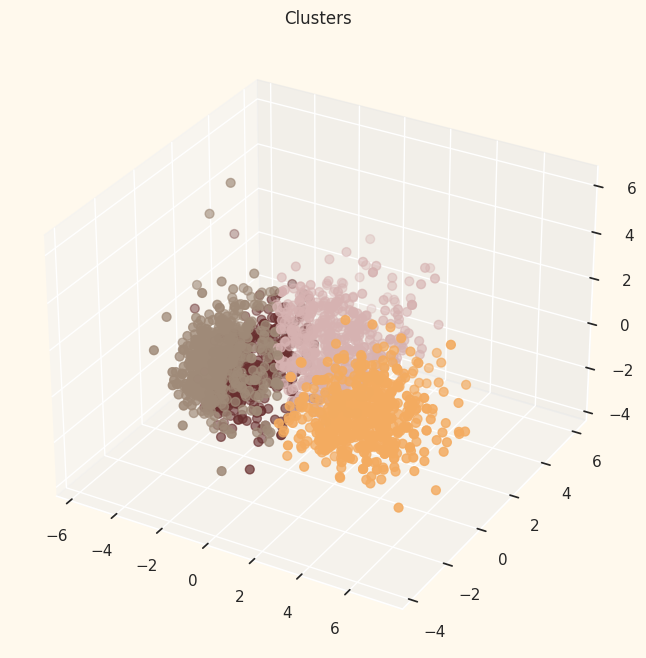

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("Clusters")
plt.show()

Vamos a evaluar el modelo.

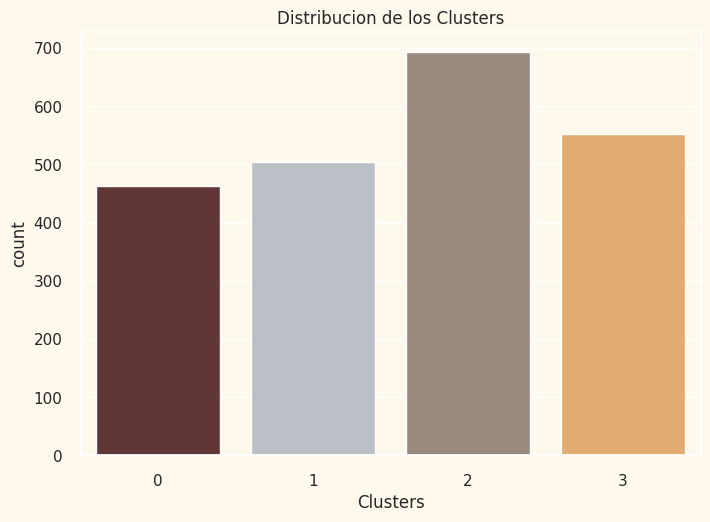

In [ ]:
#Vemos la distribución de los clientes en cada cluster
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribucion de los Clusters")
plt.show()

Parece que tenemos clusters bastante parejos.


In [ ]:
cluster0 = data[data['Clusters']==0]
cluster1 = data[data['Clusters']==1]
cluster2 = data[data['Clusters']==2]
cluster3 = data[data['Clusters']==3]

In [ ]:
cluster0.describe() # La gran mayoría son padres, edad promedio 50, educacion media

,Education,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,...,Complain,Response,Antiguedad,Edad,Gasto,Compañero,Hijos,Familia,Es_padre,Clusters
count,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,...,463.000000,463.000000,4.630000e+02,463.000000,463.000000,463.000000,463.00000,463.000000,463.000000,463.0
mean,0.585313,44677.440605,51.326134,106.356371,4.820734,34.989201,6.794816,4.954644,15.958963,2.796976,...,0.006479,0.047516,3.638018e+16,50.241901,173.874730,0.898488,1.74514,3.643629,0.997840,0.0
std,0.607279,15303.239210,28.991406,112.490175,8.172666,33.119780,10.408695,8.337062,17.049979,1.718826,...,0.080321,0.212970,1.930232e+16,9.249653,149.196598,0.302332,0.62406,0.592520,0.046474,0.0
min,0.000000,4023.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,8.640000e+13,26.000000,8.000000,0.000000,0.00000,2.000000,0.000000,0.0
25%,0.000000,35746.000000,26.000000,24.000000,0.000000,10.000000,0.000000,0.000000,4.000000,2.000000,...,0.000000,0.000000,2.177280e+16,43.000000,47.000000,1.000000,1.00000,3.000000,1.000000,0.0
50%,1.000000,44377.000000,52.000000,62.000000,2.000000,22.000000,3.000000,2.000000,10.000000,2.000000,...,0.000000,0.000000,3.438720e+16,49.000000,121.000000,1.000000,2.00000,4.000000,1.000000,0.0
75%,1.000000,52976.000000,77.500000,163.500000,6.000000,53.000000,8.000000,7.000000,23.000000,4.000000,...,0.000000,0.000000,4.985280e+16,58.000000,270.000000,1.000000,2.00000,4.000000,1.000000,0.0
max,2.000000,162397.000000,99.000000,734.000000,65.000000,171.000000,71.000000,67.000000,125.000000,15.000000,...,1.000000,1.000000,8.640000e+16,69.000000,902.000000,1.000000,3.00000,5.000000,1.000000,0.0


In [ ]:
cluster1.describe() # Son padres en mayoría, edad parecida, income más grande

,Education,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,...,Complain,Response,Antiguedad,Edad,Gasto,Compañero,Hijos,Familia,Es_padre,Clusters
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,...,504.000000,504.000000,5.040000e+02,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.0
mean,0.561508,59084.476190,48.688492,522.777778,27.904762,166.369048,37.634921,28.757937,71.621032,3.876984,...,0.011905,0.150794,5.342349e+16,49.355159,855.065476,0.666667,1.107143,2.773810,0.930556,1.0
std,0.621185,11870.386323,28.199872,300.609583,32.585701,125.642803,42.356736,34.075418,57.739124,2.421069,...,0.108565,0.358203,1.847020e+16,10.082702,346.337201,0.471873,0.504875,0.685282,0.254461,0.0
min,0.000000,2447.000000,0.000000,1.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.592000e+14,23.000000,302.000000,0.000000,0.000000,1.000000,0.000000,1.0
25%,0.000000,52821.250000,25.000000,293.000000,5.000000,86.000000,8.000000,6.000000,28.000000,2.000000,...,0.000000,0.000000,4.093200e+16,41.000000,577.750000,0.000000,1.000000,2.000000,1.000000,1.0
50%,0.000000,59962.500000,48.000000,481.500000,16.000000,138.000000,21.000000,16.000000,53.000000,3.000000,...,0.000000,0.000000,5.551200e+16,49.000000,795.000000,1.000000,1.000000,3.000000,1.000000,1.0
75%,1.000000,66387.750000,71.250000,708.250000,40.250000,217.000000,55.000000,41.000000,106.000000,5.000000,...,0.000000,0.000000,6.657120e+16,58.250000,1073.000000,1.000000,1.000000,3.000000,1.000000,1.0
max,2.000000,94871.000000,99.000000,1486.000000,199.000000,1725.000000,234.000000,195.000000,321.000000,15.000000,...,1.000000,1.000000,9.184320e+16,72.000000,2053.000000,1.000000,3.000000,5.000000,1.000000,1.0


In [ ]:
cluster2.describe()  # Educación más alta, edad mas baja, menos padres

,Education,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,...,Complain,Response,Antiguedad,Edad,Gasto,Compañero,Hijos,Familia,Es_padre,Clusters
count,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,...,693.000000,693.000000,6.930000e+02,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.0
mean,0.714286,31996.329004,47.398268,38.738817,6.375180,23.264069,8.620491,6.072150,17.139971,1.786436,...,0.011544,0.115440,4.358762e+16,40.376623,100.210678,0.502165,0.919192,2.421356,0.803752,2.0
std,0.772943,12731.690698,28.930305,62.513371,9.466587,24.931486,12.909824,8.508275,21.445502,1.224976,...,0.106898,0.319783,1.932608e+16,10.391936,101.670592,0.500356,0.552810,0.630354,0.397445,0.0
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,19.000000,5.000000,0.000000,0.000000,1.000000,0.000000,2.0
25%,0.000000,23477.000000,23.000000,5.000000,1.000000,7.000000,2.000000,1.000000,5.000000,1.000000,...,0.000000,0.000000,2.946240e+16,32.000000,37.000000,0.000000,1.000000,2.000000,1.000000,2.0
50%,1.000000,31395.000000,46.000000,15.000000,3.000000,14.000000,4.000000,3.000000,11.000000,1.000000,...,0.000000,0.000000,4.415040e+16,39.000000,63.000000,1.000000,1.000000,2.000000,1.000000,2.0
75%,1.000000,39548.000000,73.000000,42.000000,7.000000,27.000000,11.000000,8.000000,21.000000,2.000000,...,0.000000,0.000000,5.736960e+16,45.000000,122.000000,1.000000,1.000000,3.000000,1.000000,2.0
max,2.000000,153924.000000,99.000000,691.000000,87.000000,168.000000,175.000000,66.000000,262.000000,15.000000,...,1.000000,1.000000,9.184320e+16,75.000000,797.000000,1.000000,2.000000,3.000000,1.000000,2.0


In [ ]:
cluster3.describe() # Mayor ingreso de los 4, no son padres, edad de 46 promedio, sin hijos

,Education,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,...,Complain,Response,Antiguedad,Edad,Gasto,Compañero,Hijos,Familia,Es_padre,Clusters
count,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,...,552.000000,552.000000,5.520000e+02,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.0
mean,0.543478,76621.742754,49.422101,608.201087,67.983696,458.873188,99.983696,70.346014,75.724638,1.186594,...,0.005435,0.280797,4.330377e+16,46.784420,1381.112319,0.594203,0.168478,1.762681,0.166667,3.0
std,0.661292,11377.820103,29.522597,317.456631,50.700338,244.366499,65.936598,52.171066,59.912188,1.046800,...,0.073587,0.449796,1.991446e+16,13.546408,422.218690,0.491491,0.379443,0.623076,0.373016,0.0
min,0.000000,41003.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,8.640000e+13,20.000000,277.000000,0.000000,0.000000,1.000000,0.000000,3.0
25%,0.000000,70256.500000,23.000000,370.250000,26.000000,265.750000,43.000000,29.750000,31.000000,1.000000,...,0.000000,0.000000,2.769120e+16,36.000000,1059.500000,0.000000,0.000000,1.000000,0.000000,3.0
50%,0.000000,76504.500000,52.500000,559.500000,53.000000,420.000000,89.500000,56.500000,54.500000,1.000000,...,0.000000,0.000000,4.285440e+16,46.000000,1363.000000,1.000000,0.000000,2.000000,0.000000,3.0
75%,1.000000,82332.250000,74.000000,822.250000,102.000000,606.250000,149.250000,105.000000,108.000000,1.000000,...,0.000000,1.000000,5.821200e+16,58.000000,1666.250000,1.000000,0.000000,2.000000,0.000000,3.0
max,2.000000,160803.000000,99.000000,1493.000000,197.000000,1725.000000,259.000000,262.000000,249.000000,15.000000,...,1.000000,1.000000,9.184320e+16,74.000000,2525.000000,1.000000,2.000000,3.000000,1.000000,3.0


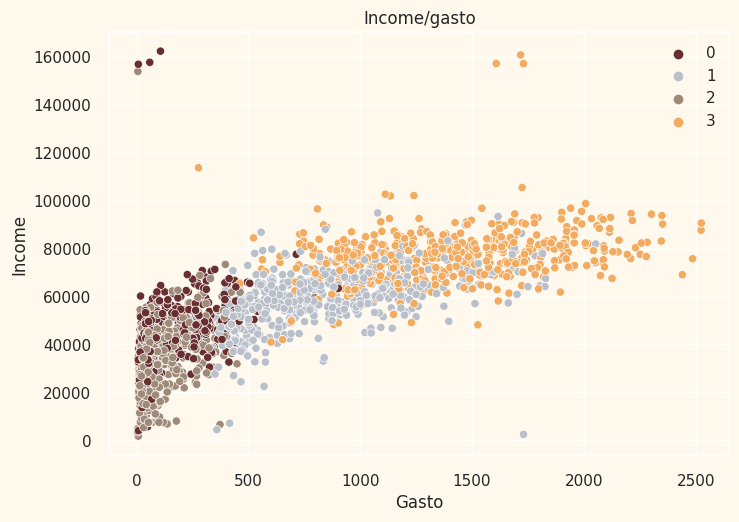

In [ ]:
pl = sns.scatterplot(data = data,x=data["Gasto"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Income/gasto")
plt.legend()
plt.show()

**Viendo este grafico podemos caracterizar los clusters segun su gasto/income*
* group 0: Bajo gasto & medio income
* group 1: medio gasto & medio income
* group 2: Bajo gasto & bajo income
* group 3: Alto gasto &  medio/alto income


<Figure size 800x550 with 0 Axes>

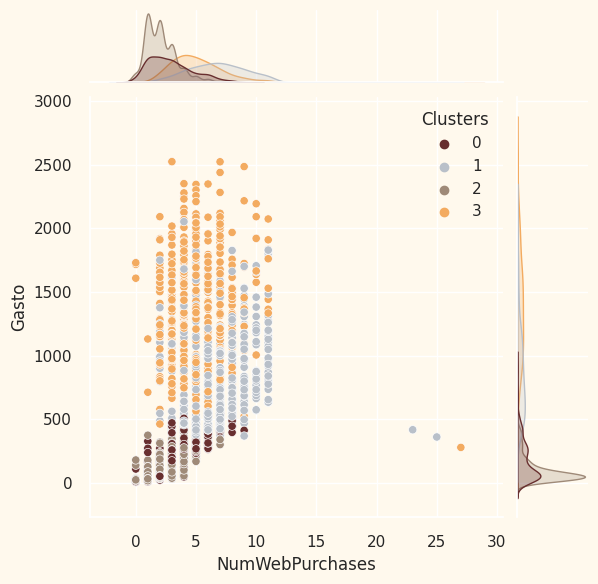

<Figure size 800x550 with 0 Axes>

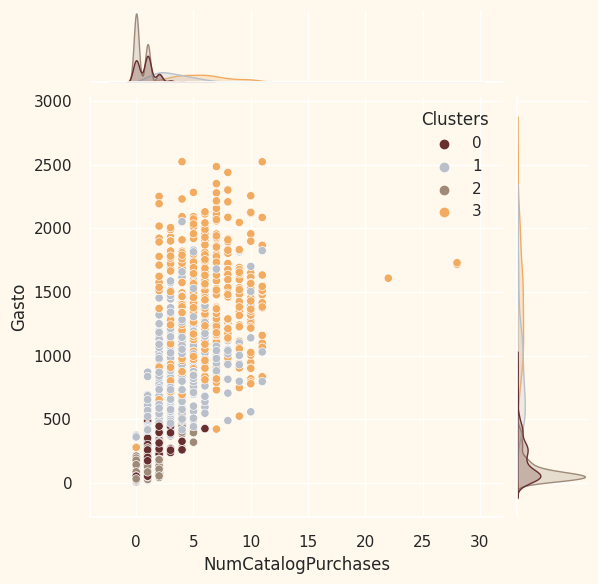

<Figure size 800x550 with 0 Axes>

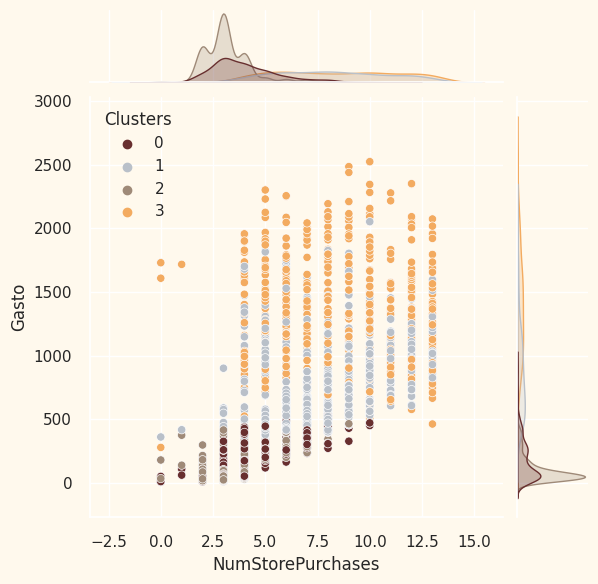

<Figure size 800x550 with 0 Axes>

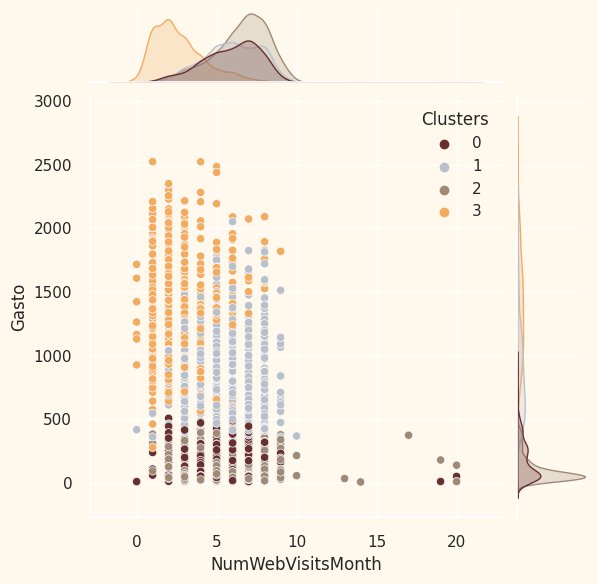

In [ ]:
#Detalles de compras por canales
Places =["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",  "NumWebVisitsMonth"]

for i in Places:
    plt.figure()
    sns.jointplot(x=data[i],y = data["Gasto"],hue=data["Clusters"], palette= pal)
    plt.show()

<a id="8"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Perfilado</p>

Ahora que hemos formado los grupos y mirado sus hábitos de compra.
Perfilaremos los clusters formados y llegaremos a una conclusión sobre quién es nuestro cliente estrella y quién necesita más atención por parte del equipo de marketing de la tienda minorista.

Para decidir que trazarémos algunas de las características que son indicativas de los rasgos personales del cliente a la luz del grupo en el que se encuentran.
Sobre la base de los resultados, llegaremos a las conclusiones.

<Figure size 800x550 with 0 Axes>

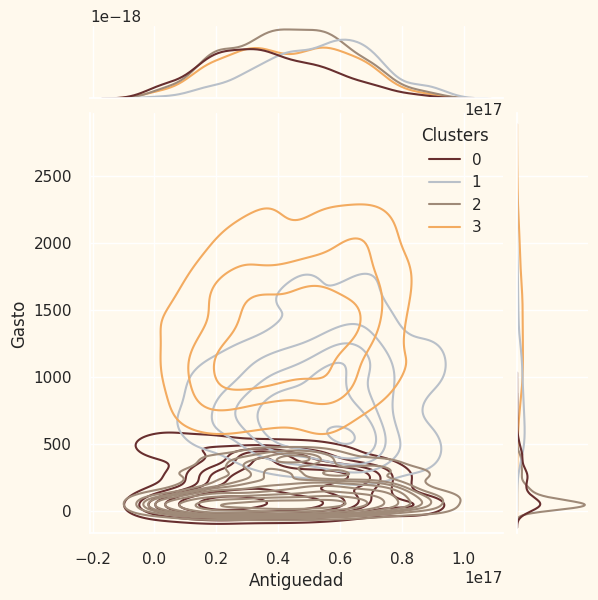

<Figure size 800x550 with 0 Axes>

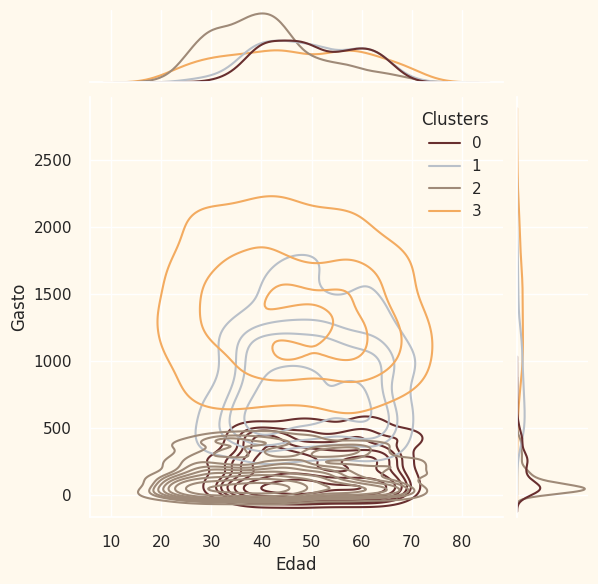

<Figure size 800x550 with 0 Axes>

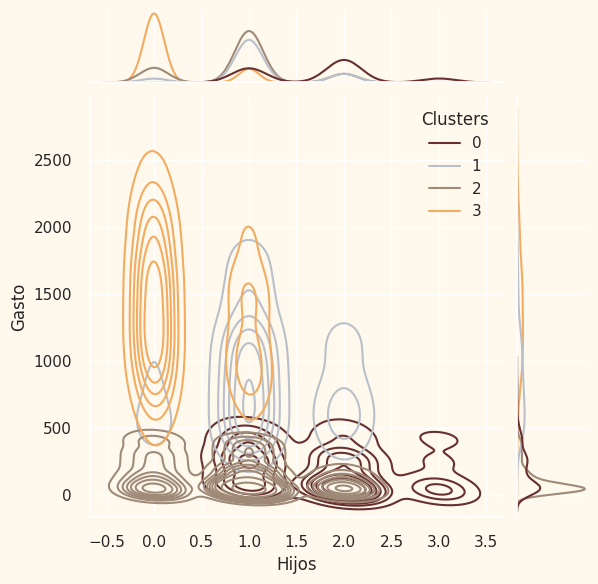

<Figure size 800x550 with 0 Axes>

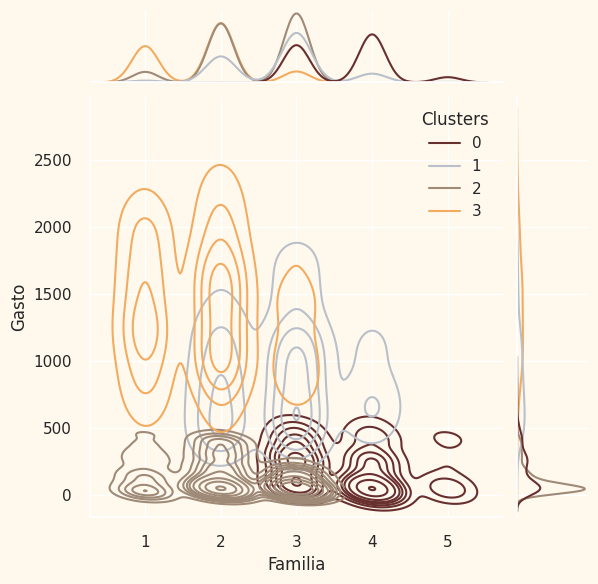

<Figure size 800x550 with 0 Axes>

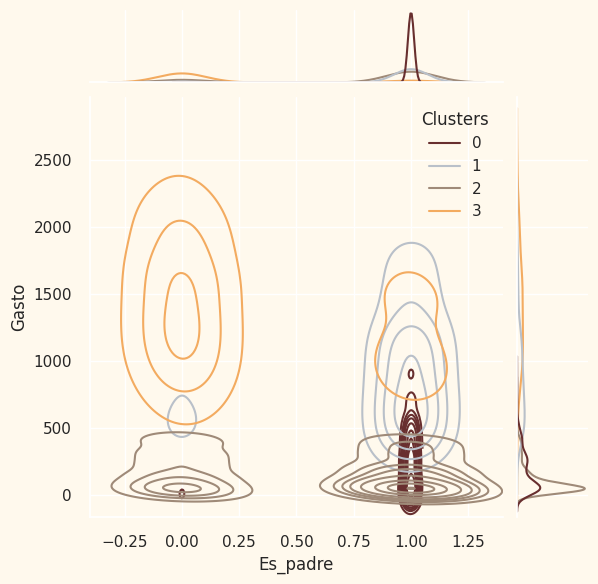

<Figure size 800x550 with 0 Axes>

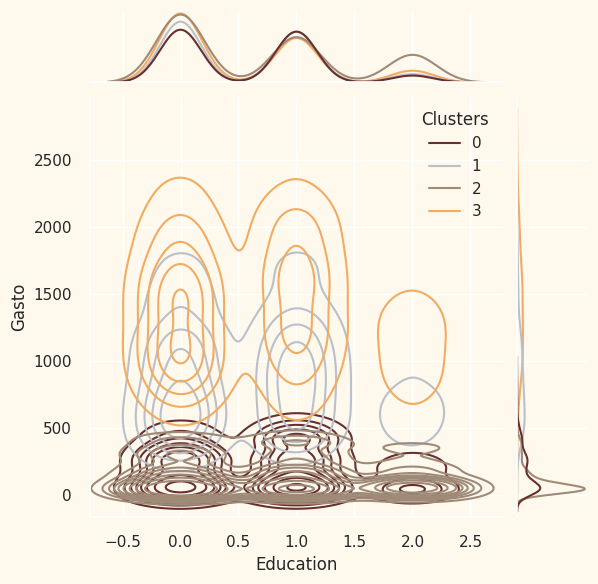

<Figure size 800x550 with 0 Axes>

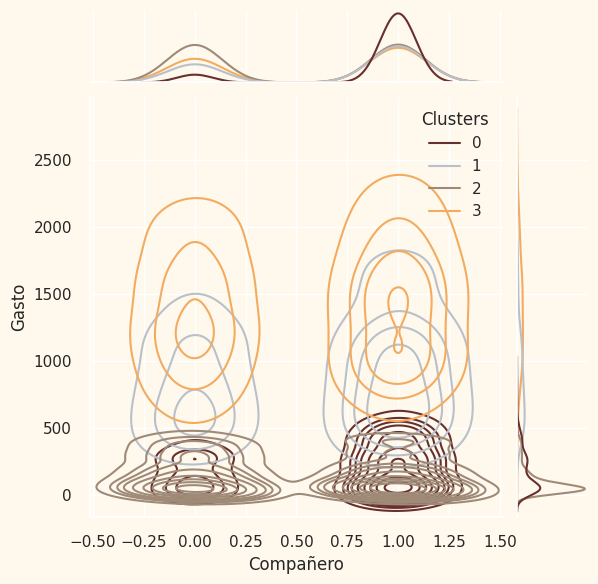

In [ ]:
Personal = ["Antiguedad", "Edad", "Hijos", "Familia", "Es_padre", "Education","Compañero"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Gasto"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()

# Las gráficas de línea muestran los puntos de mayor concentración

(estos gráficos son como mapas topográficos. Son como montañas vistas desde arriba. A la izquierda se pude ver la distribución de los datos y a la derecha su densidad en ese punto)
